# Final Project in Reinforcements Learning: Part B - DQN in the Empty Environment

## Installs

Uncomment the following cell when running on Google-Colab env:

In [50]:
'''
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install gym-minigrid
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install -U --no-cache-dir gdown --pre
'''

"\n%%capture\n!sudo apt-get update\n!sudo apt-get install -y xvfb ffmpeg freeglut3-dev\n!pip install 'imageio==2.4.0'\n!pip install gym\n!pip install gym-minigrid\n!pip install pygame\n!apt-get install python-opengl -y\n!apt install xvfb -y\n!pip install pyvirtualdisplay\n!pip install piglet\n!pip install gym\n!apt-get install python-opengl -y\n!apt install xvfb -y\n!pip install -U --no-cache-dir gdown --pre\n"

## Imports

In [51]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time
import seaborn as sns
import gym_minigrid
from gym_minigrid.wrappers import *
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from numpy import load
from numpy import save
import numpy as np
import pandas as pd
import cv2
from base64 import b64encode
import os
import torch
import torch.nn as nn
from torch.optim import SGD
from collections import namedtuple, deque
import copy
import random
import matplotlib.pyplot as plt
from enum import Enum
from abc import ABC, abstractmethod

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Display utils
Note: this cell was changed in order to support also working on windows os, as PyVirtualDisplay doesn't work on windows. link for reference: https://stackoverflow.com/questions/43270513/is-there-a-windows-equivalent-to-pyvirtualdisplay

In [52]:
if os.name == 'nt': # this means we run locally on windows
  video_count = 0
  def create_video(images):
    global video_count
    video_count += 1
    video_name = f'video_{video_count}.mp4'
    frame = images[0]
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 3, (width,height))

    for image in images:
      video.write(image)

    cv2.destroyAllWindows()
    video.release()
  
    mp4 = open(video_name,'rb').read()   
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(
      HTML(
            """
                <video width=400 controls>
                        <source src="%s" type="video/mp4">
                </video>
            """ % data_url
          )   
    )
    print(f'video file name: {video_name}')
      
else: # this is posix, as it runs online. use assigment video solution
  def create_video(images):
    video_filename = 'imageio.mp4'
    with imageio.get_writer(video_filename, fps=10) as video:
        for image in images: video.append_data(image)

    video = open(video_filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
      <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)
  display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start() 

# Env

In [53]:
from __future__ import annotations
from gym_minigrid.minigrid import COLOR_NAMES
from gym_minigrid.minigrid import Grid
from gym_minigrid.minigrid import MissionSpace
from gym_minigrid.minigrid import Door, Goal, Key, Wall, Lava, Floor
from minigrid_x import MiniGridEnv
from gym import spaces
import random

class RandomEmptyEnv_10(MiniGridEnv):
    def __init__(
        self,
        size=10, # DEFINE THE WIDTH AND HEIGHT
        agent_start_pos=(1, 1),
        agent_start_dir = 0,
        max_steps: int | None = None,
        **kwargs,
    ):

        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir

        agent_start_x_loc =random.randint(1, 6)
        agent_start_y_loc =random.randint(1, 6)

        self.agent_start_pos = (agent_start_x_loc,agent_start_y_loc)

        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )
        self.action_space = spaces.Discrete(3)
        self.walls_init = []

        # change 21-09 for random env
        self.not_goal_loc = [(col,row) for col in range(self.unwrapped.width) for row in range(self.unwrapped.height) if row == 0 or row == (self.unwrapped.width-1) or col == 0 or col == (self.unwrapped.height-1)]
        self.not_goal_loc.append(self.agent_start_pos)
        self.goal_pos = (self.grid.width - 2, self.grid.height - 2)

    def reset(self, **kwargs):
        # Randomize start position each time environment is reset
        agent_start_x_loc = random.randint(1, 6)
        agent_start_y_loc = random.randint(1, 6)
        self.agent_start_pos = (agent_start_x_loc, agent_start_y_loc)

        self.values = [0, 1, 2, 3]
        self.agent_start_dir = random.choice(self.values)

        # Recalculate not_goal_loc as it depends on the agent's start position
        self.not_goal_loc = [(col, row) for col in range(self.unwrapped.width) for row in range(self.unwrapped.height)
                             if row == 0 or row == (self.unwrapped.width - 1) or col == 0 or col == (self.unwrapped.height - 1)]
        self.not_goal_loc.append(self.agent_start_pos)

        # Call the reset method of the parent class
        return super().reset(**kwargs)
    
    # Necessary functions for environment customization:
    # - get_position and get_goal_pos: These functions help us determine whether the environment has been solved
    #   Additionally, get_goal_pos aids in gathering metrics related to the agent's performance throughout the training process
    # - is_wall_front_pos: This function assesses whether forward movement is feasible for the agent at the specific state
    
    def get_position(self):
        return self.unwrapped.agent_pos
    
    def get_goal_pos(self):
        return self.unwrapped.goal_pos
    
    def is_wall_front_pos(self):
        if 0 in self.unwrapped.front_pos or (self.unwrapped.height-1) in self.unwrapped.front_pos:
            return True
        return (tuple(self.unwrapped.front_pos) in self.unwrapped.walls_init)

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate verical separation wall
        # for i in range(0, height):
        #     self.grid.set(5, i, Wall())


        for column, row in self.walls_init:
          self.grid.set(column, row, Wall())

        self.key_pos = (6, 5)
        self.door_pos = (6, 7)

        self.goal_pos = random.choice([(8,1), (8,8), (1,8)])

        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"


## WRAPPER

In [54]:
class EMPTYRGBImgObsWrapper(gym.core.ObservationWrapper):
    """
    Wrapper to use fully observable RGB image as the only observation output,
    no language/mission. This can be used to have the agent to solve the
    gridworld in pixel space.
    """

    def __init__(self, env, tile_size=32, plot=False, preprocess= lambda x: x):
        super().__init__(env)
        self.tile_size = tile_size
        self.plot = plot
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            # #the default is (320,320,3). Tile size  = 32 X 10 (grid size)
            # TODO: BE CAREFULL TO CHANGE the shape size to be according your preprocess size/channels
            # The env information i staken from here
            shape=(320, 320, 3),
            dtype='uint8'
        )
        self.prev_door = False
        self.prev_key = False
        self.action_space = spaces.Discrete(self.action_space.n)

        #TODO: THINK AND TEST DIFFERENT PREPROCESS
        self._preprocess = lambda x: x


    def observation(self, obs):
      env = self.unwrapped

      # Call render without any unsupported keyword arguments
      rgb_img = env.render()  # Use the default rendering behavior
      return rgb_img

    def reset(self, seed = 0, options = None):
        self.prev_door = False
        self.prev_key = False
        obs, info = super().reset()
        if self.plot:
            plt.show()
        return self._preprocess(obs), info

    def step(self, action):
        #action = ACTION_MAP[action]
        obs, r, d, info, x = super().step(action)
        obs = self._preprocess(obs)

        # TODO: REWARD SHAPING
        #we encourage you to come up with a better reward function using  self.is_door_open() and self.is_carrying_key()

        return obs, r, d, info, x

Environment Customization:

In [55]:
class EnvType(Enum):
    EMPTY = 0
    KEY = 1

class EnvStochasticity(Enum):
    CONSTANT = 0
    STOCHASTIC = 1

agent_directions_space = 4
key_state_space = 2
door_state_space = 2

key_picked_up_reward = 1 # these are constant rewards
door_unlocked_reward = 1

class Direction(Enum):
    RIGHT = 0
    DOWN = 1
    LEFT = 2
    UP = 3

class StateRepresentation(Enum):
    IMAGE = 'image'
    ENCODED = 'encoded'

class EnvWrapper(gym.Env, ABC):
    '''
    This wrapper enables environment customization
    '''
    def __init__(self, env, step_reward=-0.01, goal_reward=10, state_representation=StateRepresentation.ENCODED, env_stochasticity=EnvStochasticity.CONSTANT):
        '''
        Initializes the EnvWrapper.

        Args:
            env (gym.Env): The Gym environment to be wrapped. Important: this env must be initialized before wrapping (use env.reset())
            step_reward (float, optional): The per-step reward or penalty. Default is -0.01.
            goal_reward (float, optional): The reward for reaching the goal. Default is 10.
            state_representation (StateRepr, optional): The state representation mode.
                                                        Use StateRepr.IMAGE for a full image representation, or StateRepr.ENCODED for an encoded version
                                                        Default is StateRepr.ENCODED
             env_stochasticity (EnvStochasticity, optional): The environmental stochasticity setting.
                                                        Use EnvStochasticity.CONSTANT to keep artifacts in their place upon reset,
                                                        or EnvStochasticity.STOCHASTIC to allow them to change upon reset.
                                                        Default is EnvStochasticity.CONSTANT.
        '''
        self.state_representation = state_representation
        self.is_constant = EnvStochasticity.CONSTANT == env_stochasticity

        if self.is_constant:
            self.source_env = env # keep track of the original env
        else:
            self.env = env

        self.set_params(step_reward, goal_reward)
        self.reset()

    def reset(self):
        if self.is_constant:
            self.env = copy.deepcopy(self.source_env) # open gym default implementation changes the board. override, as we do not want to change the board upon reset every time
        else:
            self.env.reset()
        return self.get_current_state()

    def set_params(self, step_reward, goal_reward):
        self.step_reward = step_reward
        self.goal_reward = goal_reward

    def get_current_state(self):
        if StateRepresentation.IMAGE == self.state_representation:
            current_state = self.env.render()
        else:
            current_state = self.get_encoded_current_state()
        return current_state

    def render(self):
        return self.env.render()

    def get_state_dim(self):
        if StateRepresentation.IMAGE == self.state_representation:
            state_dim = self.env.render().shape
        else: # this is encoded mode
            state_dim = self.get_encoded_state_dim()
        return state_dim

    def get_board_dims(self):
        cols = self.env.width - 2
        rows = self.env.height - 2
        return cols, rows

    def get_action_dim(self):
        return self.env.action_space.n

    def sample_action(self):
        available_actions = self.get_available_actions()
        sampled_action = random.choice(available_actions)
        return sampled_action

    def get_agent_position(self):
        col, row = self.env.get_position()
        return col - 1, row - 1

    @abstractmethod
    def get_available_actions(self):
        pass

    @abstractmethod
    def get_encoded_state_dim(self):
        pass

    @abstractmethod
    def get_encoded_current_state(self):
        pass

    @abstractmethod
    def step(self, action):
        pass

class EmptyEnvWrapper(EnvWrapper):
    def get_available_actions(self):
        available_actions = [0, 1]
        if not self.env.is_wall_front_pos(): # the agent is not standing in front of a wall - if so, we can proceed forward (2)
            available_actions.append(2)
        return available_actions

    def get_encoded_state_dim(self):
        cols, rows = self.get_board_dims()
        if self.is_constant:
            return (cols, rows,  # possible location of agent
                    agent_directions_space)
        else:
            return (cols, rows, # possible location of agent
                    agent_directions_space,
                    3) # 3 Possible location of the goal

    def get_goal_encoded_loc(self):
        col, row = self.env.get_goal_pos()
        if col == 8 and row == 1:
            return 0
        elif col == 1 and row == 8:
            return 1
        else: # col == 8 and row == 8:
            return 2

    def get_encoded_current_state(self):
        agent_col, agent_row = self.get_agent_position()
        agent_direction = self.env.get_direction()
        if self.is_constant:
            state = (agent_col, agent_row, agent_direction)
            return state
        else:
            goal_encoded_loc = self.get_goal_encoded_loc()
            state = (agent_col, agent_row, agent_direction, goal_encoded_loc)
            return state

    def step(self, action):
        _ = self.env.step(action)
        s_tag = self.get_current_state()
        done = self.env.get_goal_pos() == self.env.get_position() # compare agent location to target location
        r = self.goal_reward if done else self.step_reward
        return s_tag, r, done

class KeyEnvWrapper(EnvWrapper):
    def reset(self):
        self.was_key_picked_up = False
        self.was_door_unlocked = False
        return super().reset()

    def get_available_actions(self):
        available_actions = [0, 1]

        if (not self.env.is_carrying_key() and
                self.env.is_key_front_pos()):  # the agent is fronting a key - if so, we can use pick up action (3)
            available_actions.append(3)
        elif (not self.env.is_door_open() and
              self.env.is_carrying_key() and
              self.env.is_door_front_pos()):  # the agent is fronting a door it can open - if so, we can use toggle action (5)
            available_actions.append(5)
        elif (not self.env.is_wall_front_pos() or
            self.env.is_door_front_pos() and self.env.is_door_open()):  # the agent is not fronting a key, a closed door or a wall - if so, we can proceed forward (2)
            available_actions.append(2)

        return available_actions

    def get_encoded_state_dim(self):
        cols, rows = self.get_board_dims()
        if self.is_constant:
            return (cols, rows,  # agent location - 8X8 possibilities (ignoring door column)
                    agent_directions_space,  # 4 possible directions
                    key_state_space, door_state_space)  # add 2 more for key carring and door opening
        else:
            return (cols, rows, # agent location - 8X8 possibilities (ignoring door column)
                    agent_directions_space,  # 4 possible directions
                    2, rows, # key location - 2 possible columns X 8 rows
                    rows, # door location - 1 possible column X 8 rows
                    key_state_space, door_state_space)  # add 2 more for key carring and door opening

    def get_encoded_current_state(self):
        '''
        Note: the state holds the knowledge of the agent: the agent knows where it is and what its direction is,
        as well as some history of its actions: whether it has picked up the key or unlocked the door for the first time
        '''
        agent_col, agent_row = self.get_agent_position()
        agent_direction = self.env.get_direction()
        if self.is_constant:
            state = (agent_col, agent_row,
                     agent_direction,
                     int(self.was_key_picked_up), int(self.was_door_unlocked))
            return state
        else:
            key_col, key_row = self.env.get_k_pos()
            _, door_row = self.env.get_d_pos()  # use only row because door always in the same column
            state = (agent_col, agent_row,
                     agent_direction,
                     key_col - 1, key_row - 1,
                     door_row - 1,
                     int(self.was_key_picked_up), int(self.was_door_unlocked))
            return state

    def step(self, action):
        # First - log current state
        agent_had_key = self.env.is_carrying_key()
        door_was_opened = self.env.is_door_open()

        # now - perform the action and check its outcome
        _ = self.env.step(action)
        agent_has_key = self.env.is_carrying_key()
        door_is_opened = self.env.is_door_open()
        done = self.env.get_goal_pos() == self.env.get_position()

        if done:
            r = self.goal_reward
        elif not agent_had_key and agent_has_key and not self.was_key_picked_up:  # the agent picked up the key for the first time
            self.was_key_picked_up = True
            r = key_picked_up_reward
        elif not door_was_opened and door_is_opened and not self.was_door_unlocked: # the door is opened for the first time
            self.was_door_unlocked = True
            r = door_unlocked_reward
        else: # this is a regular step
            r = self.step_reward

        s_tag = self.get_current_state()

        return s_tag, r, done

Environment Creation:

In [56]:
def create_env(state_representation, env_stochasticity):
    source_env = EMPTYRGBImgObsWrapper(RandomEmptyEnv_10(render_mode='rgb_array'))
    source_env.reset()
    env = EmptyEnvWrapper(source_env, state_representation=state_representation, env_stochasticity=env_stochasticity)
    return env

The DQN algorithm:

In [57]:
import torch
import random
import torch.nn as nn
from torch.optim import SGD
from collections import namedtuple, deque
import copy
import numpy as np
import math
from enum import Enum
import torch.nn.functional as F

Transition = namedtuple('transition', ('state', 'action', 'reward', 'next_state'))

class DqnVersion(Enum):
    VANILLA = 'vanilla'
    DDQN = 'ddqn'
    DUELING = 'dueling'

    def __str__(self):
        return self.value

class QNN(nn.Module):
    def __init__(self, state_dim, action_dim, dqn_version):
        super(QNN, self).__init__()
        # log network type
        self.dqn_version = dqn_version

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(41472, state_dim)  # Intermediate dense layer

        if dqn_version == DqnVersion.DUELING: # Dueling architecture layers
            self.state_value = nn.Linear(state_dim, 1)
            self.action_advantage = nn.Linear(state_dim, action_dim)
        else: # Single output layer for VANILLA and DDQN
            self.output_layer = nn.Linear(state_dim, action_dim)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = F.relu(self.fc(x))

        if self.dqn_version == DqnVersion.DUELING:
            # Value: How good it is to be in this state
            value = self.state_value(x)
            # Advantage: How much better some actions are compared to others in this state
            advantage = self.action_advantage(x)
            # Get Q-values: value + normalized-advantage. This way, Q(s,a) = value(s) + advantage(s,a)
            q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        else: # DDQN or Vanila DQN
            q_values = self.output_layer(x)
        return q_values

class ExperienceReplayBuffer:
    def __init__(self, memory_buffer_size):
        self.buffer = deque([], maxlen=memory_buffer_size)
    def push(self, state, action, reward, next_state):
        t = (state, action, reward, next_state)
        self.buffer.append(t)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))

    def __len__(self):
        return len(self.buffer)

def state_to_tensor(state, done=False):
    if done:
        return None
    else:
        return torch.tensor(state, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

def create_policy(policy_net):
    policy_net_snapshot = copy.deepcopy(policy_net)
    def policy(s):
        '''
        This function gets a state and returns the preferable action.
        It does it by providing the state to the network and returning the action with maximal q-value
        (i.e. this is a greedy policy_net)
        '''
        state_tensor = state_to_tensor(s)
        with torch.no_grad():
            q_values = policy_net_snapshot(state_tensor)
        a = q_values.max(1)[1].view(1, 1)
        return a.item()
    return policy

def pick_action(epsilon, state, env, policy_net):
    '''
    Selects an action based on the epsilon-greedy strategy, which balances exploration and exploitation.
    '''
    if random.random() >= epsilon: # exploitation
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else: # exploration
        return torch.tensor([[env.sample_action()]], dtype=torch.long)

def update_target_net(policy_net, target_net):
    target_net.load_state_dict(policy_net.state_dict())

def update_epsilon(epsilon, ep_decay):
    ep = max(epsilon * ep_decay, 0.05)
    return ep

def train_policy_network(buffer, policy_net, target_net, batch_size, gamma, optimizer, criterion, dqn_version):
    # Step 1: sample from data and create the required tensors
    batch = buffer.sample(batch_size)
    state_tensor = torch.cat(batch.state)
    action_tensor = torch.cat(batch.action)
    reward_tensor = torch.cat(batch.reward)
    next_state_tensor = torch.cat([next_state for next_state in batch.next_state if next_state is not None])
    non_final_state_mask_tensor = torch.tensor(tuple(map(lambda next_state: next_state is not None, batch.next_state)), dtype=torch.bool)

    # Step 2: Calculate Q-values for current states and selected actions
    q_values_tensor = policy_net(state_tensor).gather(1, action_tensor)

    # Step 3: Calculate the maximum Q-values for the next states using the target network
    next_q_values_tensor = torch.zeros(batch_size)
    with torch.no_grad():
        if dqn_version == DqnVersion.DDQN: # DDQN reduces the overestimation of Q-values by using a more stable target for evaluation
            # Step 1: Action Selection - best action is selected according to the policy_net
            next_state_actions = policy_net(next_state_tensor).max(1)[1].unsqueeze(1)
            # Step 2: Action Evaluation - the evaluation is done according to target_net
            next_q_values_tensor[non_final_state_mask_tensor] = target_net(next_state_tensor).gather(1, next_state_actions).squeeze()
        else: # vanila DQN - just choose max Q
            next_q_values_tensor[non_final_state_mask_tensor] = target_net(next_state_tensor).max(1)[0] # Note: final states remains with reward of 0
    target_q_values = (next_q_values_tensor * gamma) + reward_tensor

    # Step 4: Calculate the loss and update the model accordingly
    loss = criterion(q_values_tensor, target_q_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

def dqn(env, num_episodes, batch_size, gamma, ep_decay, epsilon,
        target_freq_update, memory_buffer_size, learning_rate, steps_cutoff, train_action_value_freq_update,
        dqn_version):
    action_dim = env.get_action_dim()
    state_dim = math.prod(env.get_encoded_state_dim())
    policy_net = QNN(state_dim, action_dim, dqn_version)
    target_net = QNN(state_dim, action_dim, dqn_version)
    update_target_net(policy_net, target_net)
    criterion = torch.nn.MSELoss()

    buffer = ExperienceReplayBuffer(memory_buffer_size)
    optimizer = SGD(policy_net.parameters(), lr=learning_rate)

    cols, rows = env.get_board_dims()
    states_visits_count = np.zeros([cols, rows], dtype=float) # Initialize stats' data structures

    done_count = 0
    episodes_loss, episodes_rewards, episodes_steps = [], [], []

    for i in range(1, num_episodes+1):
        print(f'\nRunning episode {i}\\{num_episodes}\nPrinting steps progress (up to {steps_cutoff} steps): ')

        done = False
        episode_reward = 0
        episode_loss = 0
        num_steps = 1

        state = state_to_tensor(env.reset())
        agent_position = env.get_agent_position()
        states_visits_count[agent_position] += 1

        while not done and num_steps <= steps_cutoff:
            print(num_steps, end = " ")
            action = pick_action(epsilon, state, env, policy_net)
            next_state, reward, done = env.step(action.item())
            episode_reward += reward

            next_state = state_to_tensor(next_state, done)
            reward = torch.tensor([reward])
            buffer.push(state, action, reward, next_state)

            if len(buffer) >= batch_size and num_steps % train_action_value_freq_update == 0:
                loss = train_policy_network(buffer, policy_net, target_net, batch_size, gamma, optimizer, criterion, dqn_version)
                episode_loss += loss

            num_steps += 1
            epsilon = update_epsilon(epsilon, ep_decay)

            next_agent_position = env.get_agent_position()

            if agent_position != next_agent_position: # if the agent moved to a new location on the board
                states_visits_count[next_agent_position] += 1

            state = next_state
            agent_position = next_agent_position

        num_steps = steps_cutoff if not done else num_steps

        episodes_rewards.append(episode_reward)
        episodes_loss.append(episode_loss / num_steps)
        episodes_steps.append(num_steps)

        if i % target_freq_update == 0:
            update_target_net(policy_net, target_net)

        if done:
            done_count += 1

        if num_episodes // 2 == i:
            mid_train_policy = create_policy(policy_net)

    policy = create_policy(policy_net)

    return mid_train_policy, policy, states_visits_count / num_episodes, done_count, episodes_steps, episodes_rewards, episodes_loss

Policy video streaming:

In [58]:
def stream_policy(env, policy, iter_tresshold=None):
  # Step 1: collect images
  state = env.reset()
  start_time = time.time()
  done = False
  iter = 0
  images = []
  images.append(cv2.cvtColor(env.render(), cv2.COLOR_RGB2BGR)) 

  while not(iter_tresshold is not None and iter >= iter_tresshold) and not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 3:
      break
    iter +=1
    action = policy(state)
    state, reward, done = env.step(action)
    images.append(cv2.cvtColor(env.render(), cv2.COLOR_RGB2BGR)) 
  # Than - create video
  return create_video(images)

The parameters and hyperparameters:

In [59]:
ENV_PARAMS = 'Env_params'

#############################
# Experiments configuration #
#############################
'''
Training-phase parameters:
train_steps_cutoff - maximal steps allowed per episode
'''
train_steps_cutoff = 100

'''
Evaluation-phase parameters
test_steps_cutoff - maximal steps allowed per episode
'''
test_steps_cutoff = 100

'''
Default hyper-parameters values for env
'''
env_params = {'goal_reward': 10, 'step_reward': -0.01}

Reports generation:

In [60]:
palette = 'Set2'

def create_header(subplot, header):
    subplot.set_title(header)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.spines.clear()

def create_table(subplot, header, df):
    df.columns = df.columns.str.replace('_', ' ')
    table_data = [df.columns] + df.values.tolist()

    table = subplot.table(cellText=table_data, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)

    subplot.set_title(header)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.spines.clear()

    for spine in subplot.spines.values(): # remove redundent spines
        spine.set_visible(False)

def plot_bar_chart(df, column_name, tested_parameter, ax):
    df = df[[tested_parameter, column_name]]
    sns.barplot(data=df, x=tested_parameter, y=column_name, hue=tested_parameter, dodge=False, palette=palette, ax=ax)
    ax.legend_.remove()
    ax.set(xlabel=ax.get_xlabel().replace('_', ' '))
    ax.set(ylabel='')

def plot_line_graph(df, title, ax):
    ax.set_title(title)
    sns.lineplot(data=df, palette=palette, ax=ax, dashes=False)

def create_train_metric_df(train_log_dict, metric):
    res_df = pd.DataFrame()
    for param_value in train_log_dict.keys():
        df = train_log_dict[param_value]
        if metric in df:
            res_df[param_value] = df[metric]
    return res_df

def create_report(tested_parameter, train_results, train_logs_dict, test_results):
    fig = plt.figure(figsize=(12, 10))
    gs = GridSpec(7, 6, height_ratios=[0.05,
                                       1,
                                       0.05, 1,
                                       0.1,
                                       0.05, 1], hspace=0.4, wspace=0.4)

    # add headers
    parameter_header_subplot = fig.add_subplot(gs[0, :])
    create_header(parameter_header_subplot, tested_parameter.replace('_', ' '))

    train_mean_header_subplot = fig.add_subplot(gs[2, :])
    create_header(train_mean_header_subplot, 'Train metrics')

    train_graph_header_subplot = fig.add_subplot(gs[5, :])
    create_header(train_graph_header_subplot, 'Train graphs')

    # add evaluation results
    policy_evaluation_subplot = fig.add_subplot(gs[1, :])
    create_table(policy_evaluation_subplot, 'Policy evaluation results', test_results)

    # add train metrics
    total_episodes_count = train_results['total_episodes_count'].iloc[0]

    ax = fig.add_subplot(gs[3, 0:3])
    plot_bar_chart(train_results, 'done_episodes_count', tested_parameter, ax)
    ax.set_title(f'Total episodes done out of {total_episodes_count}')

    ax = fig.add_subplot(gs[3, 3:])
    plot_bar_chart(train_results, 'total_steps_avg', tested_parameter, ax)
    ax.set_title(f'Avg episode steps per {total_episodes_count} episodes')

    # Add steps, reward and loss graphs
    loss_df = create_train_metric_df(train_logs_dict, 'loss')
    steps_df = create_train_metric_df(train_logs_dict, 'steps')
    rewards_df = create_train_metric_df(train_logs_dict, 'rewards')

    if len(loss_df) > 0: # we have loss information
        plot_line_graph(loss_df, 'loss', ax=fig.add_subplot(gs[6, 0:2]))
        plot_line_graph(steps_df, 'steps', ax=fig.add_subplot(gs[6, 2:4]))
        plot_line_graph(rewards_df, 'rewards', ax=fig.add_subplot(gs[6, 4:]))
    else:
        plot_line_graph(steps_df, 'steps', ax=fig.add_subplot(gs[6, 0:3]))
        plot_line_graph(rewards_df, 'rewards', ax=fig.add_subplot(gs[6, 3:]))

conducting experiments:

In [61]:
def evaluate_policy(env, policy, steps_cutoff):
    '''
    Evaluates a given policy on the given env for a limited steps_cutoff number of steps or until the environment is solved.
    :return: A tuple containing two values:
        - steps_count: The number of steps taken during the evaluation, capped at steps_cutoff.
        - done: A boolean indicating whether the environment was solved during the evaluation.
    :rtype: tuple
    '''
    state = env.reset()
    done = False
    steps_count = 0

    while not done and steps_count < steps_cutoff:
        action = policy(state)
        state, reward, done = env.step(action)
        steps_count += 1

    return steps_count, done

def run_experiment(env, env_params, algorithm, algorithm_params, tested_parameter, tested_values):
    env_params_cpy = env_params.copy()
    algorithm_params_cpy = algorithm_params.copy()

    train_results = pd.DataFrame(columns=[tested_parameter, 'done_episodes_count', 'total_episodes_count', 'total_steps_avg'])
    test_results = pd.DataFrame(columns=[tested_parameter, 'solved', 'steps_count'])
    train_logs_dict = {}
    policies_dict = {} # this is a unique addition for the dqn implementation

    # Running test for parameter_value
    for parameter_value in tested_values:

        if tested_parameter in env_params_cpy:
            env_params_cpy[tested_parameter] = parameter_value
        else:
            algorithm_params_cpy[tested_parameter] = parameter_value

        env.set_params(**env_params_cpy)
        env.reset()

        print(f'Evaluating parameter: {tested_parameter}={parameter_value}.')

        #################
        # Step 1: Train #
        #################
        print("Start training")

        algorithm_params_cpy['env'] = env
        mid_train_policy, policy, states_visits_mean, done_count, episodes_steps, episodes_rewards, *episodes_loss = algorithm(**algorithm_params_cpy)
        episodes_loss = episodes_loss[0] if episodes_loss else [] # tabular algorithms do not provide loss information - this is relevant only for deep
        policies_dict[parameter_value] = [mid_train_policy, policy]

        # Update train resuls
        train_result_entry = {
            tested_parameter: str(parameter_value),
            'done_episodes_count': done_count,
            'total_episodes_count': algorithm_params_cpy["num_episodes"],
            'total_steps_avg': np.mean(episodes_steps)
        }
        train_results.loc[len(train_results)] = train_result_entry

        # log train process
        raw_train_log_data = {
            'episode': list(range(1, len(episodes_steps) + 1)),
            'steps': episodes_steps,
            'rewards': episodes_rewards
        }
        if episodes_loss:
            raw_train_log_data['loss'] = episodes_loss

        train_log_df = pd.DataFrame(raw_train_log_data)
        train_logs_dict[str(parameter_value)] = train_log_df

        ################
        # Step 2: Test #
        ################
        print('Start testing')
        steps_count, done = evaluate_policy(env, policy, steps_cutoff=test_steps_cutoff)

        test_result_entry = {tested_parameter: str(parameter_value), 'solved': done, 'steps_count': steps_count}
        test_results.loc[len(test_results)] = test_result_entry

    print("Generating report...")
    create_report(tested_parameter, train_results, train_logs_dict, test_results)
    return policies_dict

# Experiments

In [62]:
tested_parameter = 'dqn_version'
tested_values = [DqnVersion.DDQN, DqnVersion.DUELING, DqnVersion.VANILLA]

## Empty Constant Environment

Evaluating parameter: dqn_version=ddqn.
Start training

Running episode 1\500
Printing steps progress (up to 100 steps): 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
Running episode 2\500
Printing steps progress (up to 100 steps): 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
Running episode 3\500
Printing steps progress (up to 100 steps): 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 5

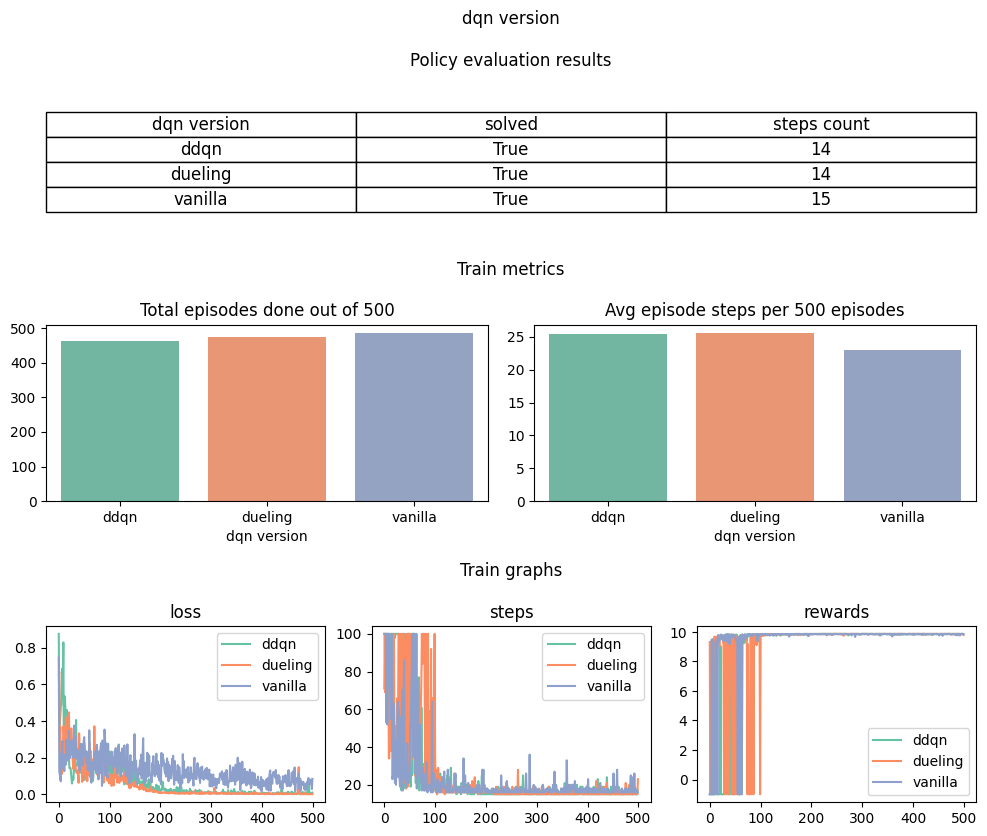

In [63]:
random.seed(42) # set seed so our environment will be the same across repetetive experiments
train_num_episodes = 500
'''
Default hyper-parameters values for the algorithms.
The tested hyperparameter will override its value in the relevant test
'''
algorithm_params = {
    'learning_rate': 0.0001,
    'gamma': 0.9,
    'epsilon': 1,
    'ep_decay': 0.999,
    'num_episodes': train_num_episodes,
    'steps_cutoff': train_steps_cutoff,
    'batch_size': 32,
    'target_freq_update': 10,
    'memory_buffer_size': 10000,
    'train_action_value_freq_update': 1
}

env = create_env(state_representation=StateRepresentation.IMAGE, env_stochasticity=EnvStochasticity.CONSTANT)
policies_dict = run_experiment(env=env, env_params=env_params,
                                algorithm=dqn, algorithm_params=algorithm_params,
                                tested_parameter=tested_parameter, tested_values=tested_values)

Stream DDQN mid-training policy:

In [64]:
mid_train_policy = policies_dict[DqnVersion.DDQN][0]
stream_policy(env, mid_train_policy)

video file name: video_1.mp4


stream DDQN final policy:

In [65]:
train_policy = policies_dict[DqnVersion.DDQN][1]
stream_policy(env, train_policy)

video file name: video_2.mp4


Stream Dueling DQN mid-training policy:

In [66]:
mid_train_policy = policies_dict[DqnVersion.DUELING][0]
stream_policy(env, mid_train_policy)

video file name: video_3.mp4


stream Dueling DQN final policy:

In [67]:
train_policy = policies_dict[DqnVersion.DUELING][1]
stream_policy(env, train_policy)

video file name: video_4.mp4


Stream Vanilla DQN mid-training policy:

In [68]:
mid_train_policy = policies_dict[DqnVersion.VANILLA][0]
stream_policy(env, mid_train_policy)

video file name: video_5.mp4


stream Dueling Vanilla final policy:

In [69]:
train_policy = policies_dict[DqnVersion.VANILLA][1]
stream_policy(env, train_policy)

video file name: video_6.mp4


## Empty Stochastic Environment

In [70]:
random.seed(42) # set seed so our environment will be the same across repetetive experiments
train_num_episodes = 1000 # override episodes cound according to env

'''
Default hyper-parameters values for the algorithms.
The tested hyperparameter will override its value in the relevant test
'''
algorithm_params = {
    'learning_rate': 0.00005,
    'gamma': 0.9,
    'epsilon': 1,
    'ep_decay': 0.999,
    'num_episodes': train_num_episodes,
    'steps_cutoff': train_steps_cutoff,
    'batch_size': 32,
    'target_freq_update': 10,
    'memory_buffer_size': 10000,
    'train_action_value_freq_update': 1
}

env = create_env(state_representation=StateRepresentation.IMAGE, env_stochasticity=EnvStochasticity.STOCHASTIC)
policies_dict = run_experiment(env=env, env_params=env_params,
                algorithm=dqn, algorithm_params=algorithm_params,
                tested_parameter=tested_parameter, tested_values=tested_values)

Evaluating parameter: dqn_version=ddqn.
Start training

Running episode 1\1000
Printing steps progress (up to 100 steps): 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
Running episode 2\1000
Printing steps progress (up to 100 steps): 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
Running episode 3\1000
Printing steps progress (up to 100 steps): 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 5

Stream DDQN mid-training policy:

In [ ]:
mid_train_policy = policies_dict[DqnVersion.DDQN][0]
stream_policy(env, mid_train_policy)

stream DDQN final policy:

In [ ]:
train_policy = policies_dict[DqnVersion.DDQN][1]
stream_policy(env, train_policy)

Stream Dueling DQN mid-training policy:

In [ ]:
mid_train_policy = policies_dict[DqnVersion.DUELING][0]
stream_policy(env, mid_train_policy)

stream Dueling DQN final policy:

In [ ]:
train_policy = policies_dict[DqnVersion.DUELING][1]
stream_policy(env, train_policy)

Stream Vanilla DQN mid-training policy:

In [ ]:
mid_train_policy = policies_dict[DqnVersion.VANILLA][0]
stream_policy(env, mid_train_policy)

stream Dueling Vanilla final policy:

In [ ]:
train_policy = policies_dict[DqnVersion.VANILLA][1]
stream_policy(env, train_policy)